In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Primer ejemplo") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Basic Structured Operations

In Chapter 4, we introduced the core abstractions of the Structured API. This chapter moves
away from the architectural concepts and toward the tactical tools you will use to manipulate
DataFrames and the data within them. This chapter focuses exclusively on fundamental
DataFrame operations and avoids aggregations, window functions, and joins. These are
discussed in subsequent chapters.

Definitionally, a DataFrame consists of a series of records (like rows in a table), that are of type
Row, and a number of columns (like columns in a spreadsheet) that represent a computation
expression that can be performed on each individual record in the Dataset. Schemas define the
name as well as the type of data in each column. Partitioning of the DataFrame defines the
layout of the DataFrame or Dataset’s physical distribution across the cluster. The partitioning
scheme defines how that is allocated. You can set this to be based on values in a certain column
or nondeterministically.

Let’s create a DataFrame with which we can work:
~~~
// in Scala
val df = spark.read.format("json")
.load("/data/flight-data/json/2015-summary.json")
~~~

In [2]:
# in Python
df = spark.read.format("json").load("../data/flight-data/json/2015-summary.json")

In [61]:
from pyspark.sql.functions import expr,col,avg,lit,date_add,to_date,desc
df1 = df.withColumn('today',lit('27-10-2022'))
df1 = df1.withColumn('w_later',date_add(to_date('today',"dd-MM-yyy"),7))
df.groupBy("DEST_COUNTRY_NAME","ORIGIN_COUNTRY_NAME").count()
df.rdd.getNumPartitions()

1

We discussed that a DataFame will have columns, and we use a schema to define them. Let’s
take a look at the schema on our current DataFrame:

In [4]:
df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



Schemas tie everything together, so they’re worth belaboring.

## Schemas
A schema defines the column names and types of a DataFrame. We can either let a data source
define the schema (called schema-on-read) or we can define it explicitly ourselves.

___WARNING___

Deciding whether you need to define a schema prior to reading in your data depends on your use case.
For ad hoc analysis, schema-on-read usually works just fine (although at times it can be a bit slow with
plain-text file formats like CSV or JSON). However, this can also lead to precision issues like a long
type incorrectly set as an integer when reading in a file. When using Spark for production Extract,
Transform, and Load (ETL), it is often a good idea to define your schemas manually, especially when
working with untyped data sources like CSV and JSON because schema inference can vary depending
on the type of data that you read in.

Let’s begin with a simple file, which we saw in Chapter 4, and let the semi-structured nature of
line-delimited JSON define the structure. This is flight data from the United States Bureau of
Transportation statistics:
~~~
// in Scala
spark.read.format("json").load("/data/flight-data/json/2015-summary.json").schema
Scala returns the following:
org.apache.spark.sql.types.StructType = ...
StructType(StructField(DEST_COUNTRY_NAME,StringType,true),
StructField(ORIGIN_COUNTRY_NAME,StringType,true),
StructField(count,LongType,true))
~~~

In [6]:
# in Python
spark.read.format("json").load("../data/flight-data/json/2015-summary.json").schema

StructType(List(StructField(DEST_COUNTRY_NAME,StringType,true),StructField(ORIGIN_COUNTRY_NAME,StringType,true),StructField(count,LongType,true)))

A schema is a StructType made up of a number of fields, StructFields, that have a name,
type, a Boolean flag which specifies whether that column can contain missing or null values,
and, finally, users can optionally specify associated metadata with that column. The metadata is a
way of storing information about this column (Spark uses this in its machine learning library).

Schemas can contain other StructTypes (Spark’s complex types). We will see this in Chapter 6
when we discuss working with complex types. If the types in the data (at runtime) do not match
the schema, Spark will throw an error. The example that follows shows how to create and
enforce a specific schema on a DataFrame.
~~~
// in Scala
import org.apache.spark.sql.types.{StructField, StructType, StringType, LongType}
import org.apache.spark.sql.types.Metadata
val myManualSchema = StructType(Array(
StructField("DEST_COUNTRY_NAME", StringType, true),
StructField("ORIGIN_COUNTRY_NAME", StringType, true),
StructField("count", LongType, false,
Metadata.fromJson("{\"hello\":\"world\"}"))
))
val df = spark.read.format("json").schema(myManualSchema)
.load("/data/flight-data/json/2015-summary.json")
~~~
Here’s how to do the same in Python:

In [8]:
# in Python
from pyspark.sql.types import StructField, StructType, StringType, LongType
myManualSchema = StructType([
    StructField("DEST_COUNTRY_NAME", StringType(), True),
    StructField("ORIGIN_COUNTRY_NAME", StringType(), True),
    StructField("count", LongType(), False, metadata={"hello":"world"})
])

df = (spark.read.format("json")
      .schema(myManualSchema)
      .load("../data/flight-data/json/2015-summary.json"))
df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



As discussed in Chapter 4, we cannot simply set types via the per-language types because Spark
maintains its own type information. Let’s now discuss what schemas define: columns.

## Columns and Expressions
Columns in Spark are similar to columns in a spreadsheet, R dataframe, or pandas DataFrame.
You can select, manipulate, and remove columns from DataFrames and these operations are
represented as expressions.

To Spark, columns are logical constructions that simply represent a value computed on a perrecord basis by means of an expression. This means that to have a real value for a column, we
need to have a row; and to have a row, we need to have a DataFrame. You cannot manipulate an
individual column outside the context of a DataFrame; you must use Spark transformations
within a DataFrame to modify the contents of a column.
#### Columns
There are a lot of different ways to construct and refer to columns but the two simplest ways are
by using the col or column functions. To use either of these functions, you pass in a column
name:
~~~
// in Scala
import org.apache.spark.sql.functions.{col, column}
col("someColumnName")
column("someColumnName")
# in Python
from pyspark.sql.functions import col, column
col("someColumnName")
column("someColumnName")
~~~
We will stick to using col throughout this book. As mentioned, this column might or might not
exist in our DataFrames. Columns are not resolved until we compare the column names with
those we are maintaining in the catalog. Column and table resolution happens in the analyzer
phase, as discussed in Chapter 4.

___NOTE___

We just mentioned two different ways of referring to columns. Scala has some unique language
features that allow for more shorthand ways of referring to columns. The following bits of syntactic
sugar perform the exact same thing, namely creating a column, but provide no performance
improvement:
~~~
// in Scala
\$"myColumn"
\'myColumn
~~~
The $ allows us to designate a string as a special string that should refer to an expression. The tick
mark (') is a special thing called a symbol; this is a Scala-specific construct of referring to some
identifier. They both perform the same thing and are shorthand ways of referring to columns by name.
You’ll likely see all of the aforementioned references when you read different people’s Spark code.
We leave it to you to use whatever is most comfortable and maintainable for you and those with whom
you work.

___Explicit column references___

If you need to refer to a specific DataFrame’s column, you can use the col method on the
specific DataFrame. This can be useful when you are performing a join and need to refer to a
specific column in one DataFrame that might share a name with another column in the joined
DataFrame. We will see this in Chapter 8. As an added benefit, Spark does not need to resolve
this column itself (during the analyzer phase) because we did that for Spark:
~~~
df.col("count")
~~~
#### Expressions
We mentioned earlier that columns are expressions, but what is an expression? An expression is
a set of transformations on one or more values in a record in a DataFrame. Think of it like a
function that takes as input one or more column names, resolves them, and then potentially
applies more expressions to create a single value for each record in the dataset. Importantly, this
“single value” can actually be a complex type like a Map or Array. We’ll see more of the
complex types in Chapter 6.

In the simplest case, an expression, created via the expr function, is just a DataFrame column
reference. In the simplest case, expr("someCol") is equivalent to col("someCol")

___Columns as expressions___

Columns provide a subset of expression functionality. If you use col() and want to perform
transformations on that column, you must perform those on that column reference. When using
an expression, the expr function can actually parse transformations and column references from
a string and can subsequently be passed into further transformations. Let’s look at some
examples.

expr("someCol - 5") is the same transformation as performing col("someCol") - 5, or even

expr("someCol") - 5. That’s because Spark compiles these to a logical tree specifying the
order of operations. This might be a bit confusing at first, but remember a couple of key points:
* Columns are just expressions.
* Columns and transformations of those columns compile to the same logical plan as
parsed expressions.

Let’s ground this with an example:
~~~
(((col("someCol") + 5) * 200) - 6) < col("otherCol")
~~~
Figure 5-1 shows an overview of that logical tree.
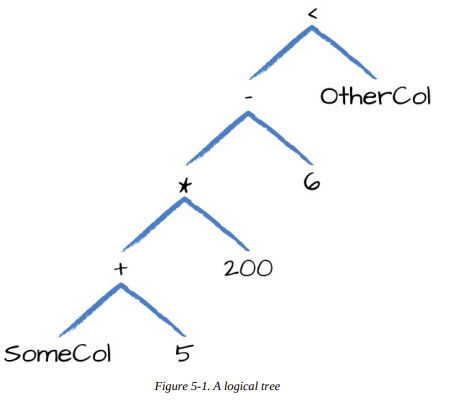
This might look familiar because it’s a directed acyclic graph. This graph is represented
equivalently by the following code:
~~~
// in Scala
import org.apache.spark.sql.functions.expr
expr("(((someCol + 5) * 200) - 6) < otherCol")
# in Python
from pyspark.sql.functions import expr
expr("(((someCol + 5) * 200) - 6) < otherCol")
~~~
This is an extremely important point to reinforce. Notice how the previous expression is actually
valid SQL code, as well, just like you might put in a SELECT statement? That’s because this SQL
expression and the previous DataFrame code compile to the same underlying logical tree prior to
execution. This means that you can write your expressions as DataFrame code or as SQL
expressions and get the exact same performance characteristics. This is discussed in Chapter 4.

___Accessing a DataFrame’s columns___

Sometimes, you’ll need to see a DataFrame’s columns, which you can do by using something
like printSchema; however, if you want to programmatically access columns, you can use the
columns property to see all columns on a DataFrame:
~~~
spark.read.format("json").load("/data/flight-data/json/2015-summary.json")
.columns
~~~

## Records and Rows
In Spark, each row in a DataFrame is a single record. Spark represents this record as an object of
type Row. Spark manipulates Row objects using column expressions in order to produce usable
values. Row objects internally represent arrays of bytes. The byte array interface is never shown
to users because we only use column expressions to manipulate them.

You’ll notice commands that return individual rows to the driver will always return one or more
Row types when we are working with DataFrames.

___NOTE___

We use lowercase “row” and “record” interchangeably in this chapter, with a focus on the latter. A
capitalized Row refers to the Row object.
Let’s see a row by calling first on our DataFrame:
~~~
df.first()
~~~
#### Creating Rows
You can create rows by manually instantiating a Row object with the values that belong in each
column. It’s important to note that only DataFrames have schemas. Rows themselves do not have
schemas. This means that if you create a Row manually, you must specify the values in the same
order as the schema of the DataFrame to which they might be appended (we will see this when
we discuss creating DataFrames):
~~~
// in Scala
import org.apache.spark.sql.Row
val myRow = Row("Hello", null, 1, false)
# in Python
from pyspark.sql import Row
myRow = Row("Hello", None, 1, False)
~~~
Accessing data in rows is equally as easy: you just specify the position that you would like. In
Scala or Java, you must either use the helper methods or explicitly coerce the values. However,
in Python or R, the value will automatically be coerced into the correct type:
~~~
// in Scala
myRow(0) // type Any
myRow(0).asInstanceOf[String] // String
myRow.getString(0) // String
myRow.getInt(2) // Int
# in Python
myRow[0]
myRow[2]
~~~
You can also explicitly return a set of Data in the corresponding Java Virtual Machine (JVM)
objects by using the Dataset APIs. This is covered in Chapter 11.

## DataFrame Transformations
Now that we briefly defined the core parts of a DataFrame, we will move onto manipulating
DataFrames. When working with individual DataFrames there are some fundamental objectives.
These break down into several core operations, as depicted in Figure 5-2:
* We can add rows or columns
* We can remove rows or columns
* We can transform a row into a column (or vice versa)
* We can change the order of rows based on the values in columns
![image.png](attachment:image.png)
Luckily, we can translate all of these into simple transformations, the most common being those
that take one column, change it row by row, and then return our results.
#### Creating DataFrames
As we saw previously, we can create DataFrames from raw data sources. This is covered
extensively in Chapter 9; however, we will use them now to create an example DataFrame (for
illustration purposes later in this chapter, we will also register this as a temporary view so that we
can query it with SQL and show off basic transformations in SQL, as well):
~~~
// in Scala
val df = spark.read.format("json")
.load("/data/flight-data/json/2015-summary.json")
df.createOrReplaceTempView("dfTable")
~~~

In [9]:
# in Python
df = spark.read.format("json").load("../data/flight-data/json/2015-summary.json")
df.createOrReplaceTempView("dfTable")

We can also create DataFrames on the fly by taking a set of rows and converting them to a
DataFrame.
~~~
// in Scala
import org.apache.spark.sql.Row
import org.apache.spark.sql.types.{StructField, StructType, StringType, LongType}
val myManualSchema = new StructType(Array(
new StructField("some", StringType, true),
new StructField("col", StringType, true),
new StructField("names", LongType, false)))
val myRows = Seq(Row("Hello", null, 1L))
val myRDD = spark.sparkContext.parallelize(myRows)
val myDf = spark.createDataFrame(myRDD, myManualSchema)
myDf.show()
~~~
___NOTE___

In Scala, we can also take advantage of Spark’s implicits in the console (and if you import them in
your JAR code) by running toDF on a Seq type. This does not play well with null types, so it’s not
necessarily recommended for production use cases.

~~~
// in Scala
val myDF = Seq(("Hello", 2, 1L)).toDF("col1", "col2", "col3")
# in Python
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType
myManualSchema = StructType([
StructField("some", StringType(), True),
StructField("col", StringType(), True),
StructField("names", LongType(), False)
])
myRow = Row("Hello", None, 1)
myDf = spark.createDataFrame([myRow], myManualSchema)
myDf.show()
Giving an output of:
+-----+----+-----+
| some| col|names|
+-----+----+-----+
|Hello|null| 1|
+-----+----+-----+
~~~
Now that you know how to create DataFrames, let’s take a look at their most useful methods that
you’re going to be using: the select method when you’re working with columns or expressions,
and the selectExpr method when you’re working with expressions in strings. Naturally some
transformations are not specified as methods on columns; therefore, there exists a group of
functions found in the org.apache.spark.sql.functions package.
With these three tools, you should be able to solve the vast majority of transformation challenges
that you might encounter in DataFrames.

#### select and selectExpr
select and selectExpr allow you to do the DataFrame equivalent of SQL queries on a table of data:
~~~
-- in SQL
SELECT * FROM dataFrameTable
SELECT columnName FROM dataFrameTable
SELECT columnName * 10, otherColumn, someOtherCol as c FROM dataFrameTable
~~~
In the simplest possible terms, you can use them to manipulate columns in your DataFrames.
Let’s walk through some examples on DataFrames to talk about some of the different ways of
approaching this problem. The easiest way is just to use the select method and pass in the
column names as strings with which you would like to work:
~~~
// in Scala
df.select("DEST_COUNTRY_NAME").show(2)
-- in SQL
SELECT DEST_COUNTRY_NAME FROM dfTable LIMIT 2
Giving an output of:
+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
| United States|
| United States|
+-----------------+
~~~

In [16]:
# in Python
df.select("DEST_COUNTRY_NAME").show(2)

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows



You can select multiple columns by using the same style of query, just add more column name
strings to your select method call:
~~~
// in Scala
df.select("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME").show(2)
-- in SQL
SELECT DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME FROM dfTable LIMIT 2
Giving an output of:
+-----------------+-------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|
+-----------------+-------------------+
| United States| Romania|
| United States| Croatia|
+-----------------+-------------------+
~~~

In [20]:
# in Python
df.select("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME").show(2)

+-----------------+-------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|
+-----------------+-------------------+
|    United States|            Romania|
|    United States|            Croatia|
+-----------------+-------------------+
only showing top 2 rows



As discussed in “Columns and Expressions”, you can refer to columns in a number of different
ways; all you need to keep in mind is that you can use them interchangeably:
~~~
// in Scala
import org.apache.spark.sql.functions.{expr, col, column}
df.select(
df.col("DEST_COUNTRY_NAME"),
col("DEST_COUNTRY_NAME"),
column("DEST_COUNTRY_NAME"),
'DEST_COUNTRY_NAME,
\$"DEST_COUNTRY_NAME",
expr("DEST_COUNTRY_NAME"))
.show(2)
~~~

In [28]:
# in Python
from pyspark.sql.functions import expr, col
df.select(
    expr("DEST_COUNTRY_NAME"),
    col("DEST_COUNTRY_NAME")).show(2)

+-----------------+-----------------+
|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|
+-----------------+-----------------+
|    United States|    United States|
|    United States|    United States|
+-----------------+-----------------+
only showing top 2 rows



In [29]:
df.select(col("DEST_COUNTRY_NAME"), "DEST_COUNTRY_NAME",expr("DEST_COUNTRY_NAME")).show(1)

+-----------------+-----------------+-----------------+
|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|
+-----------------+-----------------+-----------------+
|    United States|    United States|    United States|
+-----------------+-----------------+-----------------+
only showing top 1 row



As we’ve seen thus far, expr is the most flexible reference that we can use. It can refer to a plain
column or a string manipulation of a column. To illustrate, let’s change the column name, and
then change it back by using the AS keyword and then the alias method on the column:
~~~
// in Scala
df.select(expr("DEST_COUNTRY_NAME AS destination")).show(2)
-- in SQL
SELECT DEST_COUNTRY_NAME as destination FROM dfTable LIMIT 2
~~~

In [30]:
# in Python
df.select(expr("DEST_COUNTRY_NAME AS destination")).show(2)

+-------------+
|  destination|
+-------------+
|United States|
|United States|
+-------------+
only showing top 2 rows



This changes the column name to “destination.” You can further manipulate the result of your
expression as another expression:
~~~
// in Scala
df.select(expr("DEST_COUNTRY_NAME as destination").alias("DEST_COUNTRY_NAME"))
.show(2)
~~~

In [31]:
# in Python
df.select(expr("DEST_COUNTRY_NAME as destination").alias("DEST_COUNTRY_NAME")).show(2)

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows



The preceding operation changes the column name back to its original name.

Because select followed by a series of expr is such a common pattern, Spark has a shorthand
for doing this efficiently: selectExpr. This is probably the most convenient interface for
everyday use:
~~~
// in Scala
df.selectExpr("DEST_COUNTRY_NAME as newColumnName", "DEST_COUNTRY_NAME").show(2)
~~~

In [32]:
# in Python
df.selectExpr("DEST_COUNTRY_NAME as newColumnName", "DEST_COUNTRY_NAME").show(2)

+-------------+-----------------+
|newColumnName|DEST_COUNTRY_NAME|
+-------------+-----------------+
|United States|    United States|
|United States|    United States|
+-------------+-----------------+
only showing top 2 rows



This opens up the true power of Spark. We can treat selectExpr as a simple way to build up
complex expressions that create new DataFrames. In fact, we can add any valid non-aggregating
SQL statement, and as long as the columns resolve, it will be valid! Here’s a simple example that
adds a new column withinCountry to our DataFrame that specifies whether the destination and
origin are the same:
~~~
// in Scala
df.selectExpr(
"*", // include all original columns
"(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry")
.show(2)
-- in SQL
SELECT *, (DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry
FROM dfTable
LIMIT 2
Giving an output of:
+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
| United States| Romania| 15| false|
| United States| Croatia| 1| false|
+-----------------+-------------------+-----+-------------+
~~~

In [33]:
# in Python
df.selectExpr(
"*", # all original columns
"(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry").show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



With select expression, we can also specify aggregations over the entire DataFrame by taking advantage of the functions that we have. These look just like what we have been showing so far:
~~~
// in Scala
df.selectExpr("avg(count)", "count(distinct(DEST_COUNTRY_NAME))").show(2)
-- in SQL
SELECT avg(count), count(distinct(DEST_COUNTRY_NAME)) FROM dfTable LIMIT 2
Giving an output of:
+-----------+---------------------------------+
| avg(count)|count(DISTINCT DEST_COUNTRY_NAME)|
+-----------+---------------------------------+
|1770.765625| 132|
+-----------+---------------------------------+
~~~

In [36]:
# in Python
df.selectExpr("avg(count)", "count(distinct(DEST_COUNTRY_NAME))").show()

+-----------+---------------------------------+
| avg(count)|count(DISTINCT DEST_COUNTRY_NAME)|
+-----------+---------------------------------+
|1770.765625|                              132|
+-----------+---------------------------------+



#### Converting to Spark Types (Literals)
Sometimes, we need to pass explicit values into Spark that are just a value (rather than a new
column). This might be a constant value or something we’ll need to compare to later on. The
way we do this is through literals. This is basically a translation from a given programming
language’s literal value to one that Spark understands. Literals are expressions and you can use
them in the same way:
~~~
// in Scala
import org.apache.spark.sql.functions.lit
df.select(expr("*"), lit(1).as("One")).show(2)
In SQL, literals are just the specific value:
-- in SQL
SELECT *, 1 as One FROM dfTable LIMIT 2
Giving an output of:
+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|One|
+-----------------+-------------------+-----+---+
| United States| Romania| 15| 1|
| United States| Croatia| 1| 1|
+-----------------+-------------------+-----+---+
~~~

In [37]:
# in Python
from pyspark.sql.functions import lit
df.select(expr("*"), lit(1).alias("One")).show(2)

+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|One|
+-----------------+-------------------+-----+---+
|    United States|            Romania|   15|  1|
|    United States|            Croatia|    1|  1|
+-----------------+-------------------+-----+---+
only showing top 2 rows



This will come up when you might need to check whether a value is greater than some constant
or other programmatically created variable.
####  Adding Columns
There’s also a more formal way of adding a new column to a DataFrame, and that’s by using the
withColumn method on our DataFrame. For example, let’s add a column that just adds the
number one as a column:
~~~
// in Scala
df.withColumn("numberOne", lit(1)).show(2)
~~~

Resulting in:
... DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME, count, Destination
~~~

-- in SQL
SELECT *, 1 as numberOne FROM dfTable LIMIT 2
Giving an output of:
+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|numberOne|
+-----------------+-------------------+-----+---------+
| United States| Romania| 15| 1|
| United States| Croatia| 1| 1|
+-----------------+-------------------+-----+---------+
~~~

In [38]:
# in Python
df.withColumn("numberOne", lit(1)).show(2)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|numberOne|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|        1|
|    United States|            Croatia|    1|        1|
+-----------------+-------------------+-----+---------+
only showing top 2 rows



Let’s do something a bit more interesting and make it an actual expression. In the next example,
we’ll set a Boolean flag for when the origin country is the same as the destination country:
~~~
// in Scala
df.withColumn("withinCountry", expr("ORIGIN_COUNTRY_NAME == DEST_COUNTRY_NAME"))
.show(2)
~~~

In [39]:
# in Python
df.withColumn("withinCountry", expr("ORIGIN_COUNTRY_NAME == DEST_COUNTRY_NAME"))\
.show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



Notice that the withColumn function takes two arguments: the column name and the expression
that will create the value for that given row in the DataFrame. Interestingly, we can also rename
a column this way. The SQL syntax is the same as we had previously, so we can omit it in this
example:

In [42]:
df.withColumn("Destination", expr("DEST_COUNTRY_NAME")).show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|  Destination|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|United States|
|    United States|            Croatia|    1|United States|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



#### Renaming Columns
Although we can rename a column in the manner that we just described, another alternative is to
use the withColumnRenamed method. This will rename the column with the name of the string in
the first argument to the string in the second argument:
~~~
// in Scala
df.withColumnRenamed("DEST_COUNTRY_NAME", "dest").columns
~~~

In [43]:
# in Python
df.withColumnRenamed("DEST_COUNTRY_NAME", "dest").columns

['dest', 'ORIGIN_COUNTRY_NAME', 'count']

#### Reserved Characters and Keywords
One thing that you might come across is reserved characters like spaces or dashes in column
names. Handling these means escaping column names appropriately. In Spark, we do this by
using backtick (`) characters. Let’s use withColumn, which you just learned about to create a
column with reserved characters. We’ll show two examples—in the one shown here, we don’t
need escape characters, but in the next one, we do:
~~~
// in Scala
import org.apache.spark.sql.functions.expr
val dfWithLongColName = df.withColumn(
"This Long Column-Name",
expr("ORIGIN_COUNTRY_NAME"))
~~~

In [44]:
# in Python
dfWithLongColName = df.withColumn(
"This Long Column-Name",
expr("ORIGIN_COUNTRY_NAME"))

We don’t need escape characters here because the first argument to withColumn is just a string
for the new column name. In this example, however, we need to use backticks because we’re
referencing a column in an expression:
~~~
// in Scala
dfWithLongColName.selectExpr(
"`This Long Column-Name`",
"`This Long Column-Name` as `new col`")
.show(2)

-- in SQL
SELECT `This Long Column-Name`, `This Long Column-Name` as `new col`
FROM dfTableLong LIMIT 2
~~~

In [50]:
# in Python
dfWithLongColName.selectExpr(
"`This Long Column-Name`",
"`This Long Column-Name` as `new col`")\
.show(2)
dfWithLongColName.createOrReplaceTempView("dfTableLong")

+---------------------+-------+
|This Long Column-Name|new col|
+---------------------+-------+
|              Romania|Romania|
|              Croatia|Croatia|
+---------------------+-------+
only showing top 2 rows



We can refer to columns with reserved characters (and not escape them) if we’re doing an
explicit string-to-column reference, which is interpreted as a literal instead of an expression. We
only need to escape expressions that use reserved characters or keywords. The following two
examples both result in the same DataFrame:
~~~
// in Scala
dfWithLongColName.select(col("This Long Column-Name")).columns
~~~

In [53]:
# in Python
dfWithLongColName.select(expr("`This Long Column-Name`")).columns


['This Long Column-Name']

In [54]:
dfWithLongColName.select(col("This Long Column-Name")).columns

['This Long Column-Name']

#### Case Sensitivity
By default Spark is case insensitive; however, you can make Spark case sensitive by setting the
configuration:
~~~
-- in SQL
set spark.sql.caseSensitive true.
~~~
#### Removing Columns
Now that we’ve created this column, let’s take a look at how we can remove columns from
DataFrames. You likely already noticed that we can do this by using select. However, there is
also a dedicated method called drop:
~~~
df.drop("ORIGIN_COUNTRY_NAME").columns
~~~
We can drop multiple columns by passing in multiple columns as arguments:
~~~
dfWithLongColName.drop("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME")
~~~

#### Changing a Column’s Type (cast)
Sometimes, we might need to convert from one type to another; for example, if we have a set of
StringType that should be integers. We can convert columns from one type to another by casting the column from one type to another. For instance, let’s convert our count column from
an integer to a type Long:
~~~
df.withColumn("count2", col("count").cast("long"))
-- in SQL
SELECT *, cast(count as long) AS count2 FROM dfTable
~~~
#### Filtering Rows
To filter rows, we create an expression that evaluates to true or false. You then filter out the rows
with an expression that is equal to false. The most common way to do this with DataFrames is to
create either an expression as a String or build an expression by using a set of column
manipulations. There are two methods to perform this operation: you can use where or filter
and they both will perform the same operation and accept the same argument types when used
with DataFrames. We will stick to where because of its familiarity to SQL; however, filter is
valid as well.

___NOTE___

When using the Dataset API from either Scala or Java, filter also accepts an arbitrary function that
Spark will apply to each record in the Dataset. See Chapter 11 for more information.

The following filters are equivalent, and the results are the same in Scala and Python:
~~~
-- in SQL
SELECT * FROM dfTable WHERE count < 2 LIMIT 2
Giving an output of:
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
| United States| Croatia| 1|
| United States| Singapore| 1|
+-----------------+-------------------+-----+
~~~

In [60]:
df.filter(col("count") < 2).show(2)
df.where("count < 2").show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
+-----------------+-------------------+-----+
only showing top 2 rows

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
+-----------------+-------------------+-----+
only showing top 2 rows



Instinctually, you might want to put multiple filters into the same expression. Although this is
possible, it is not always useful, because Spark automatically performs all filtering operations at
the same time regardless of the filter ordering. This means that if you want to specify multiple
AND filters, just chain them sequentially and let Spark handle the rest:
~~~
// in Scala
df.where(col("count") < 2).where(col("ORIGIN_COUNTRY_NAME") =!= "Croatia")
.show(2)
-- in SQL
SELECT * FROM dfTable WHERE count < 2 AND ORIGIN_COUNTRY_NAME != "Croatia"
LIMIT 2
~~~

In [62]:
# in Python
df.where(col("count") < 2).where(col("ORIGIN_COUNTRY_NAME") != "Croatia")\
.show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 2 rows



#### Getting Unique Rows
A very common use case is to extract the unique or distinct values in a DataFrame. These values
can be in one or more columns. The way we do this is by using the distinct method on a
DataFrame, which allows us to deduplicate any rows that are in that DataFrame. For instance,
let’s get the unique origins in our dataset. This, of course, is a transformation that will return a
new DataFrame with only unique rows:
~~~
// in Scala
df.select("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME").distinct().count()
-- in SQL
SELECT COUNT(DISTINCT(ORIGIN_COUNTRY_NAME, DEST_COUNTRY_NAME)) FROM dfTable
Results in 256.
// in Scala
df.select("ORIGIN_COUNTRY_NAME").distinct().count()
-- in SQL
SELECT COUNT(DISTINCT ORIGIN_COUNTRY_NAME) FROM dfTable
Results in 125
~~~

In [63]:
# in Python
df.select("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME").distinct().count()

256

In [64]:
# in Python
df.select("ORIGIN_COUNTRY_NAME").distinct().count()

125

#### Random Samples
Sometimes, you might just want to sample some random records from your DataFrame. You can
do this by using the sample method on a DataFrame, which makes it possible for you to specify
a fraction of rows to extract from a DataFrame and whether you’d like to sample with or without
replacement:
~~~
val seed = 5
val withReplacement = false
val fraction = 0.5
df.sample(withReplacement, fraction, seed).count()
~~~

In [66]:
# in Python
seed = 5
withReplacement = False
fraction = 0.5
df.sample(withReplacement, fraction, seed).count()

138

#### Random Splits
Random splits can be helpful when you need to break up your DataFrame into a random “splits”
of the original DataFrame. This is often used with machine learning algorithms to create training,
validation, and test sets. In this next example, we’ll split our DataFrame into two different
DataFrames by setting the weights by which we will split the DataFrame (these are the
arguments to the function). Because this method is designed to be randomized, we will also
specify a seed (just replace seed with a number of your choosing in the code block). It’s
important to note that if you don’t specify a proportion for each DataFrame that adds up to one,
they will be normalized so that they do:
~~~
// in Scala
val dataFrames = df.randomSplit(Array(0.25, 0.75), seed)
dataFrames(0).count() > dataFrames(1).count() // False
~~~

In [68]:
# in Python
dataFrames = df.randomSplit([0.25, 0.75], seed)
dataFrames[0].count() > dataFrames[1].count() # False

True

#### Concatenating and Appending Rows (Union)
As you learned in the previous section, DataFrames are immutable. This means users cannot
append to DataFrames because that would be changing it. To append to a DataFrame, you must
union the original DataFrame along with the new DataFrame. This just concatenates the two DataFramess. To union two DataFrames, you must be sure that they have the same schema and
number of columns; otherwise, the union will fail.

___WARNING___

Unions are currently performed based on location, not on the schema. This means that columns will
not automatically line up the way you think they might.
~~~
// in Scala
import org.apache.spark.sql.Row
val schema = df.schema
val newRows = Seq(
Row("New Country", "Other Country", 5L),
Row("New Country 2", "Other Country 3", 1L)
)
val parallelizedRows = spark.sparkContext.parallelize(newRows)
val newDF = spark.createDataFrame(parallelizedRows, schema)
df.union(newDF)
.where("count = 1")
.where(\$"ORIGIN_COUNTRY_NAME" =!= "United States")
.show() // get all of them and we'll see our new rows at the end
~~~
In Scala, you must use the =!= operator so that you don’t just compare the unevaluated column
expression to a string but instead to the evaluated one:

In [75]:
# in Python
from pyspark.sql import Row
schema = df.schema
newRows = [
    Row("New Country", "Other Country", 5),
    Row("New Country 2", "Other Country 3", 1)
]
parallelizedRows = spark.sparkContext.parallelize(newRows)
newDF = spark.createDataFrame(parallelizedRows, schema)
# in Python
df.union(newDF)\
.where("count = 1")\
.where(col("ORIGIN_COUNTRY_NAME") != "United States")\
.show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
|    United States|          Gibraltar|    1|
|    United States|             Cyprus|    1|
|    United States|            Estonia|    1|
|    United States|          Lithuania|    1|
|    United States|           Bulgaria|    1|
|    United States|            Georgia|    1|
|    United States|            Bahrain|    1|
|    United States|   Papua New Guinea|    1|
|    United States|         Montenegro|    1|
|    United States|            Namibia|    1|
|    New Country 2|    Other Country 3|    1|
+-----------------+-------------------+-----+



As expected, you’ll need to use this new DataFrame reference in order to refer to the DataFrame
with the newly appended rows. A common way to do this is to make the DataFrame into a view
or register it as a table so that you can reference it more dynamically in your code.


#### Sorting Rows
When we sort the values in a DataFrame, we always want to sort with either the largest or
smallest values at the top of a DataFrame. There are two equivalent operations to do this sort
and orderBy that work the exact same way. They accept both column expressions and strings as
well as multiple columns. The default is to sort in ascending order:
~~~
// in Scala
df.sort("count").show(5)
df.orderBy("count", "DEST_COUNTRY_NAME").show(5)
df.orderBy(col("count"), col("DEST_COUNTRY_NAME")).show(5)
~~~

In [76]:
# in Python
df.sort("count").show(5)
df.orderBy("count", "DEST_COUNTRY_NAME").show(5)
df.orderBy(col("count"), col("DEST_COUNTRY_NAME")).show(5)

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|               Malta|      United States|    1|
|Saint Vincent and...|      United States|    1|
|       United States|            Croatia|    1|
|       United States|          Gibraltar|    1|
|       United States|          Singapore|    1|
+--------------------+-------------------+-----+
only showing top 5 rows

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|     Burkina Faso|      United States|    1|
|    Cote d'Ivoire|      United States|    1|
|           Cyprus|      United States|    1|
|         Djibouti|      United States|    1|
|        Indonesia|      United States|    1|
+-----------------+-------------------+-----+
only showing top 5 rows

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--

To more explicitly specify sort direction, you need to use the asc and desc functions if operating
on a column. These allow you to specify the order in which a given column should be sorted:
~~~
// in Scala
import org.apache.spark.sql.functions.{desc, asc}
df.orderBy(expr("count desc")).show(2)
df.orderBy(desc("count"), asc("DEST_COUNTRY_NAME")).show(2)
-- in SQL
SELECT * FROM dfTable ORDER BY count DESC, DEST_COUNTRY_NAME ASC LIMIT 2
~~~

In [91]:
# in Python
from pyspark.sql.functions import desc, asc
df.orderBy(desc("count")).show(5)
df.orderBy(col("count").desc(), col("DEST_COUNTRY_NAME").asc()).show(2)

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
|           Canada|      United States|  8399|
|    United States|             Mexico|  7187|
|           Mexico|      United States|  7140|
+-----------------+-------------------+------+
only showing top 5 rows

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
+-----------------+-------------------+------+
only showing top 2 rows



An advanced tip is to use asc_nulls_first, desc_nulls_first, asc_nulls_last, or
desc_nulls_last to specify where you would like your null values to appear in an ordered
DataFrame.
For optimization purposes, it’s sometimes advisable to sort within each partition before another
set of transformations. You can use the sortWithinPartitions method to do this:
~~~
// in Scala
spark.read.format("json").load("/data/flight-data/json/*-summary.json")
.sortWithinPartitions("count")
~~~
We will discuss this more when we look at tuning and optimization in Part III.

In [95]:
# in Python
spark.read.format("json").load("../data/flight-data/json/*-summary.json")\
.sortWithinPartitions(desc("count")).show(10)

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
|           Canada|      United States|  8399|
|    United States|             Mexico|  7187|
|           Mexico|      United States|  7140|
|   United Kingdom|      United States|  2025|
|    United States|     United Kingdom|  1970|
|            Japan|      United States|  1548|
|    United States|              Japan|  1496|
|          Germany|      United States|  1468|
+-----------------+-------------------+------+
only showing top 10 rows



#### Limit
Oftentimes, you might want to restrict what you extract from a DataFrame; for example, you
might want just the top ten of some DataFrame. You can do this by using the limit method:
~~~
// in Scala
df.limit(5).show()
# in Python
df.limit(5).show()
-- in SQL
SELECT * FROM dfTable LIMIT 6
// in Scala
df.orderBy(expr("count desc")).limit(6).show()
# in Python
df.orderBy(expr("count desc")).limit(6).show()
-- in SQL
SELECT * FROM dfTable ORDER BY count desc LIMIT 6
~~~
#### Repartition and Coalesce
Another important optimization opportunity is to partition the data according to some frequently
filtered columns, which control the physical layout of data across the cluster including the
partitioning scheme and the number of partitions.
Repartition will incur a full shuffle of the data, regardless of whether one is necessary. This
means that you should typically only repartition when the future number of partitions is greater
than your current number of partitions or when you are looking to partition by a set of columns:
~~~
// in Scala
df.rdd.getNumPartitions // 1
# in Python
df.rdd.getNumPartitions() # 1
// in Scala
df.repartition(5)
# in Python
df.repartition(5)
~~~
If you know that you’re going to be filtering by a certain column often, it can be worth
repartitioning based on that column:
~~~
// in Scala
df.repartition(col("DEST_COUNTRY_NAME"))
# in Python
df.repartition(col("DEST_COUNTRY_NAME"))
You can optionally specify the number of partitions you would like, too:
// in Scala
df.repartition(5, col("DEST_COUNTRY_NAME"))
# in Python
df.repartition(5, col("DEST_COUNTRY_NAME"))
~~~
Coalesce, on the other hand, will not incur a full shuffle and will try to combine partitions. This
operation will shuffle your data into five partitions based on the destination country name, and
then coalesce them (without a full shuffle):
~~~
// in Scala
df.repartition(5, col("DEST_COUNTRY_NAME")).coalesce(2)
# in Python
df.repartition(5, col("DEST_COUNTRY_NAME")).coalesce(2)
~~~
#### Collecting Rows to the Driver
As discussed in previous chapters, Spark maintains the state of the cluster in the driver. There are
times when you’ll want to collect some of your data to the driver in order to manipulate it on
your local machine.
Thus far, we did not explicitly define this operation. However, we used several different methods
for doing so that are effectively all the same. collect gets all data from the entire DataFrame,
take selects the first N rows, and show prints out a number of rows nicely.
~~~
// in Scala
val collectDF = df.limit(10)
collectDF.take(5) // take works with an Integer count
collectDF.show() // this prints it out nicely
collectDF.show(5, false)
collectDF.collect()
# in Python
collectDF = df.limit(10)
collectDF.take(5) # take works with an Integer count
collectDF.show() # this prints it out nicely
collectDF.show(5, False)
collectDF.collect()
~~~
There’s an additional way of collecting rows to the driver in order to iterate over the entire
dataset. The method toLocalIterator collects partitions to the driver as an iterator. This
method allows you to iterate over the entire dataset partition-by-partition in a serial manner:
~~~
collectDF.toLocalIterator()
~~~

___WARNING___

Any collection of data to the driver can be a very expensive operation! If you have a large dataset and
call collect, you can crash the driver. If you use toLocalIterator and have very large partitions,
you can easily crash the driver node and lose the state of your application. This is also expensive
because we can operate on a one-by-one basis, instead of running computation in parallel.

## Conclusion
This chapter covered basic operations on DataFrames. You learned the simple concepts and tools
that you will need to be successful with Spark DataFrames. Chapter 6 covers in much greater
detail all of the different ways in which you can manipulate the data in those DataFrames.